# **Generate music with an RNN**

https://www.tensorflow.org/tutorials/audio/music_generation

This tutorial shows you how to generate musical notes using a simple recurrent neural network (RNN). You will train a model using a collection of piano MIDI files from the MAESTRO dataset. Given a sequence of notes, your model will learn to predict the next note in the sequence. You can generate longer sequences of notes by calling the model repeatedly.

This tutorial contains complete code to parse and create MIDI files. You can learn more about how RNNs work by visiting the Text generation with an RNN tutorial.

# Setup
This tutorial uses the pretty_midi library to create and parse MIDI files, and pyfluidsynth for generating audio playback in Colab.

In [1]:
!pip install fluidsynth
!pip install pretty_midi
!pip install --upgrade pyfluidsynth


  Preparing metadata (setup.py) ... done
  Created wheel for fluidsynth: filename=fluidsynth-0.2-py3-none-any.whl size=4513 sha256=1f6de838c0e3339e2dbf1d43f06cf671ddff01a191b57a5b9976264d298c9a0a
  Stored in directory: /root/.cache/pip/wheels/44/4b/81/dee2d535b2dd27af13c230ba49aa6f05a5dff0f57c68acef55
Successfully built fluidsynth
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 3.9 MB/s eta 0:00:0000:0100:010m
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 4.9 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.9-py3-none-any.whl size=5591955 sha256=92b5ce12fa9696c6940e16e052ed00e98c70876e20cfbe55218a378daf386404
  Stored in directory: /root/.cache/pip/wheels/ad/74/7c/a06473ca8dcb63efb98c1e67667ce39d52100f837835ea18fa
Successfully built pretty_midi


In [2]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Dict, List, Optional, Sequence, Tuple

In [3]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000

Download the Maestro dataset

In [4]:
data_dir = pathlib.Path('data/maestro-v2.0.0')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'maestro-v2.0.0-midi.zip',
      origin='https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip',
      extract=True,
      cache_dir='.', cache_subdir='data',
  )

59252736/59243107 [==============================] - 3s 0us/step


The dataset contains about 1,200 MIDI files.



In [5]:
filenames = glob.glob(str(data_dir/'**/*.mid*'))
print('Number of files:', len(filenames))

Number of files: 1282


# **Process a MIDI file**
First, use pretty_midi to parse a single MIDI file and inspect the format of the notes. If you would like to download the MIDI file below to play on your computer, you can do so in colab by writing

In [6]:
sample_file = filenames[3]
print(sample_file)

data/maestro-v2.0.0/2015/MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_06_R1_2015_wav--2.midi


Generate a PrettyMIDI object for the sample MIDI file.



In [7]:
pm = pretty_midi.PrettyMIDI(sample_file)

Play the sample file. The playback widget may take several seconds to load.



In [8]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
    waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
    # Take a sample of the generated waveform to mitigate kernel resets
    waveform_short = waveform[:seconds*_SAMPLING_RATE]
    return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [9]:
pm

In [10]:
# display_audio(pm)

Do some inspection on the MIDI file. What kinds of instruments are used?



In [11]:
print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)

Number of instruments: 1
Instrument name: Acoustic Grand Piano


Extract notes

pitch : https://www.youtube.com/watch?v=E-rbBIAoO34


In [12]:
for i, note in enumerate(instrument.notes[:10]):
  note_name = pretty_midi.note_number_to_name(note.pitch)
  duration = note.end - note.start
  print(f'{i}: pitch={note.pitch}, note_name={note_name},'
        f' duration={duration:.4f}')

0: pitch=55, note_name=G3, duration=0.3979
1: pitch=59, note_name=B3, duration=0.4052
2: pitch=62, note_name=D4, duration=0.3979
3: pitch=79, note_name=G5, duration=0.6760
4: pitch=78, note_name=F#5, duration=0.1052
5: pitch=76, note_name=E5, duration=0.0646
6: pitch=74, note_name=D5, duration=0.0521
7: pitch=75, note_name=D#5, duration=0.1010
8: pitch=76, note_name=E5, duration=0.0771
9: pitch=71, note_name=B4, duration=0.0594


You will use three variables to represent a note when training the model: pitch, step and duration. The pitch is the perceptual quality of the sound as a MIDI note number. The step is the time elapsed from the previous note or start of the track. The duration is how long the note will be playing in seconds and is the difference between the note end and note start times.

Extract the notes from the sample MIDI file.

In [13]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
    pm = pretty_midi.PrettyMIDI(midi_file)
    instrument = pm.instruments[0]
    notes = collections.defaultdict(list)

    # Sort the notes by start time
    sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
    prev_start = sorted_notes[0].start

    for note in sorted_notes:
        start = note.start
        end = note.end
        notes['pitch'].append(note.pitch)
        notes['start'].append(start)
        notes['end'].append(end)
        notes['step'].append(start - prev_start)
        notes['duration'].append(end - start)
        prev_start = start

    return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [14]:
raw_notes = midi_to_notes(sample_file)
raw_notes.head()

,pitch,start,end,step,duration
0,79,1.014583,1.690625,0.000000,0.676042
1,59,1.075000,1.480208,0.060417,0.405208
2,55,1.082292,1.480208,0.007292,0.397917
3,62,1.087500,1.485417,0.005208,0.397917
4,78,1.692708,1.797917,0.605208,0.105208


It may be easier to interpret the note names rather than the pitches, so you can use the function below to convert from the numeric pitch values to note names. The note name shows the type of note, accidental and octave number (e.g. C#4).

In [15]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10]

array(['G5', 'B3', 'G3', 'D4', 'F#5', 'E5', 'D5', 'D#5', 'E5', 'B4'],
      dtype='<U3')

To visualize the musical piece, plot the note pitch, start and end across the length of the track (i.e. piano roll). Start with the first 100 notes

In [16]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
    if count:
        title = f'First {count} notes'
    else:
        title = f'Whole track'
        count = len(notes['pitch'])
    plt.figure(figsize=(20, 4))
    plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
    plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
    plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
    plt.xlabel('Time [s]')
    plt.ylabel('Pitch')
    _ = plt.title(title)

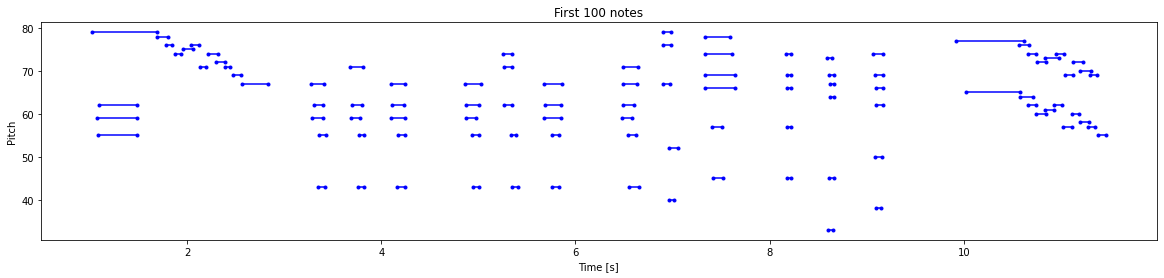

In [17]:
plot_piano_roll(raw_notes, count=100)


Plot the notes for the entire track.



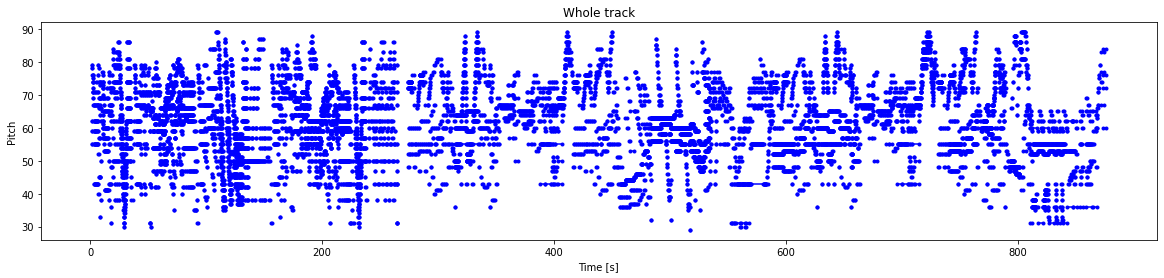

In [18]:
plot_piano_roll(raw_notes)

Check the distribution of each note variable.



In [19]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))

  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

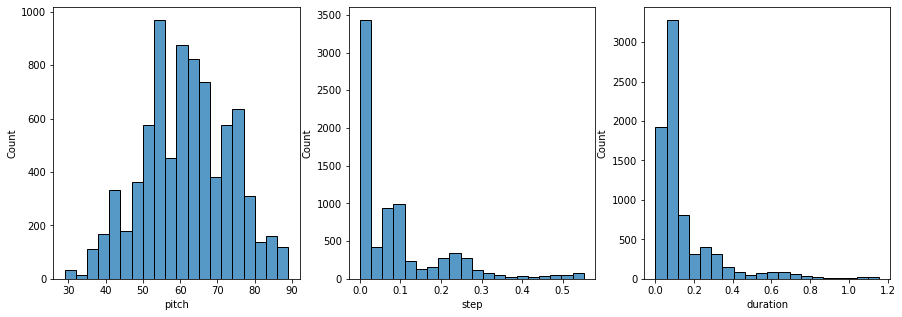

In [20]:
plot_distributions(raw_notes)

# **Create a MIDI file**
You can generate your own MIDI file from a list of notes using the function below.

In [21]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str, 
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [22]:
example_file = 'example.midi'
example_pm = notes_to_midi(
    raw_notes, out_file=example_file, instrument_name=instrument_name)

Play the generated MIDI file and see if there is any difference.



In [23]:
# display_audio(example_pm)

As before, you can write files.download(example_file) to download and play this file.
# **Create the training dataset**
Create the training dataset by extracting notes from the MIDI files. You can start by using a small number of files, and experiment later with more. This may take a couple minutes.


In [24]:
num_files = 5
all_notes = []
for f in filenames[:num_files]:
  notes = midi_to_notes(f)
  all_notes.append(notes)

all_notes = pd.concat(all_notes)

In [25]:
n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

Number of notes parsed: 22429


Next, create a tf.data.Dataset from the parsed notes.



In [26]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

In [27]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

2022-12-02 13:23:58.191048: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 13:23:58.284228: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 13:23:58.285129: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 13:23:58.287878: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

You will train the model on batches of sequences of notes. Each example will consist of a sequence of notes as the input features, and the next note as the label. In this way, the model will be trained to predict the next note in a sequence. You can find a diagram describing this process (and more details) in Text classification with an RNN.

You can use the handy window function with size seq_length to create the features and labels in this format.

In [28]:
def create_sequences(
    dataset: tf.data.Dataset, 
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)

  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

Set the sequence length for each example. Experiment with different lengths (e.g. 50, 100, 150) to see which one works best for the data, or use hyperparameter tuning. The size of the vocabulary (vocab_size) is set to 128 representing all the pitches supported by pretty_midi.

In [29]:
seq_length = 25
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

The shape of the dataset is (100,1), meaning that the model will take 100 notes as input, and learn to predict the following note as output.

In [30]:
for seq, target in seq_ds.take(1):
    print('sequence shape:', seq.shape)
    print('sequence elements (first 10):', seq[0: 10])
    print()
    print('target:', target)

sequence shape: (25, 3)
sequence elements (first 10): tf.Tensor(
[[0.53125    0.         0.05      ]
 [0.5234375  0.05729167 0.13333333]
 [0.53125    0.05833333 1.53541667]
 [0.46875    0.30416667 0.19375   ]
 [0.4375     0.01875    0.175     ]
 [0.46875    0.34166667 0.171875  ]
 [0.4375     0.021875   0.125     ]
 [0.46875    0.35104167 0.265625  ]
 [0.4375     0.01354167 0.484375  ]
 [0.6015625  0.32083333 0.365625  ]], shape=(10, 3), dtype=float64)

target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=56.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=0.3625000000000007>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=0.12812499999999982>}


2022-12-02 13:24:00.858537: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Batch the examples, and configure the dataset for performance.



In [31]:
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [32]:
train_ds.element_spec

(TensorSpec(shape=(64, 25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

# **Create and train the model**
The model will have three outputs, one for each note variable. For step and duration, you will use a custom loss function based on mean squared error that encourages the model to output non-negative values.

In [33]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [34]:
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 25, 3)]      0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 128)          67584       input_1[0][0]                    
__________________________________________________________________________________________________
duration (Dense)                (None, 1)            129         lstm[0][0]                       
__________________________________________________________________________________________________
pitch (Dense)                   (None, 128)          16512       lstm[0][0]                       
______________________________________________________________________________________________

Testing the model.evaluate function, you can see that the pitch loss is significantly greater than the step and duration losses. Note that loss is the total loss computed by summing all the other losses and is currently dominated by the pitch loss.

In [35]:
losses = model.evaluate(train_ds, return_dict=True)
losses

2022-12-02 13:24:05.325398: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


350/350 [==============================] - 6s 3ms/step - loss: 4.9908 - duration_loss: 0.1106 - pitch_loss: 4.8490 - step_loss: 0.0312


{'loss': 4.990786075592041,
 'duration_loss': 0.11060408502817154,
 'pitch_loss': 4.848999977111816,
 'step_loss': 0.031182894483208656}

One way balance this is to use the loss_weights argument to compile:



In [36]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)

The loss then becomes the weighted sum of the individual losses.



In [37]:
model.evaluate(train_ds, return_dict=True)

350/350 [==============================] - 2s 3ms/step - loss: 0.3842 - duration_loss: 0.1106 - pitch_loss: 4.8490 - step_loss: 0.0312


{'loss': 0.38423702120780945,
 'duration_loss': 0.11060408502817154,
 'pitch_loss': 4.848999977111816,
 'step_loss': 0.031182894483208656}

**Train the model.**



In [38]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [39]:
%%time
epochs = 50

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/50
350/350 [==============================] - 3s 4ms/step - loss: 0.3139 - duration_loss: 0.0814 - pitch_loss: 4.0952 - step_loss: 0.0277
Epoch 2/50
350/350 [==============================] - 1s 4ms/step - loss: 0.3002 - duration_loss: 0.0769 - pitch_loss: 3.9402 - step_loss: 0.0262
Epoch 3/50
350/350 [==============================] - 2s 5ms/step - loss: 0.2980 - duration_loss: 0.0763 - pitch_loss: 3.9128 - step_loss: 0.0260
Epoch 4/50
350/350 [==============================] - 1s 4ms/step - loss: 0.2956 - duration_loss: 0.0762 - pitch_loss: 3.8698 - step_loss: 0.0258
Epoch 5/50
350/350 [==============================] - 1s 4ms/step - loss: 0.2925 - duration_loss: 0.0758 - pitch_loss: 3.8305 - step_loss: 0.0252
Epoch 6/50
350/350 [==============================] - 1s 4ms/step - loss: 0.2910 - duration_loss: 0.0752 - pitch_loss: 3.8152 - step_loss: 0.0250
Epoch 7/50
350/350 [==============================] - 1s 4ms/step - loss: 0.2893 - duration_loss: 0.0744 - pitch_loss: 3.803

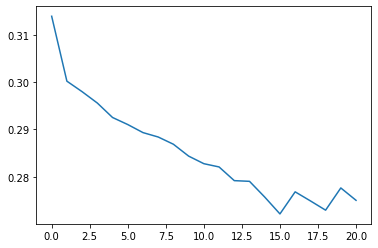

In [40]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

# **Generate notes**
To use the model to generate notes, you will first need to provide a starting sequence of notes. The function below generates one note from a sequence of notes.

For note pitch, it draws a sample from the softmax distribution of notes produced by the model, and does not simply pick the note with the highest probability. Always picking the note with the highest probability would lead to repetitive sequences of notes being generated.

The temperature parameter can be used to control the randomness of notes generated. You can find more details on temperature in Text generation with an RNN.

In [41]:
def predict_next_note(
    notes: np.ndarray, 
    keras_model: tf.keras.Model, 
    temperature: float = 1.0) -> int:
  """Generates a note IDs using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']

  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

Now generate some notes. You can play around with temperature and the starting sequence in next_notes and see what happens.

In [42]:
temperature = 2.0
num_predictions = 120

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

In [43]:
generated_notes.head(10)

,pitch,step,duration,start,end
0,76,0.238529,0.080992,0.238529,0.319521
1,50,0.104521,0.040334,0.343050,0.383384
2,74,0.150060,0.075844,0.493110,0.568953
3,84,0.136381,0.107347,0.629490,0.736837
4,84,0.133202,0.115842,0.762693,0.878535
5,80,0.135490,0.136879,0.898183,1.035062
6,84,0.135351,0.136619,1.033534,1.170153
7,84,0.134836,0.142954,1.168370,1.311324
8,86,0.134849,0.144527,1.303219,1.447746
9,86,0.134725,0.148378,1.437944,1.586322


In [44]:
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
# display_audio(out_pm)

In [45]:
# !pip install google.colab

In [46]:
# from google.colab import files
# files.download(out_file)

Visualize the generated notes.



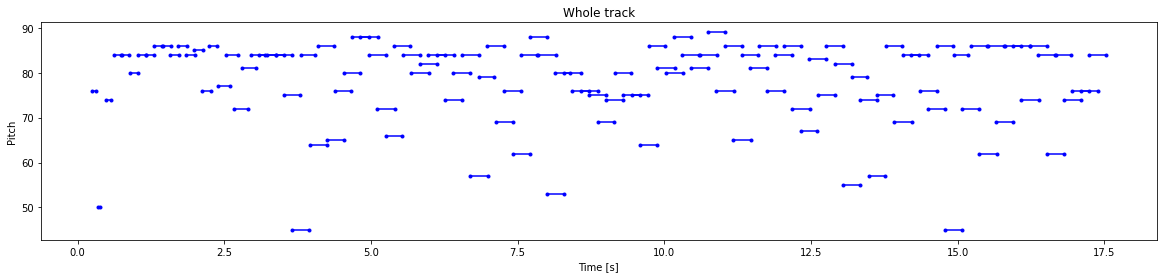

In [47]:
plot_piano_roll(generated_notes)

Check the distributions of pitch, step and duration.



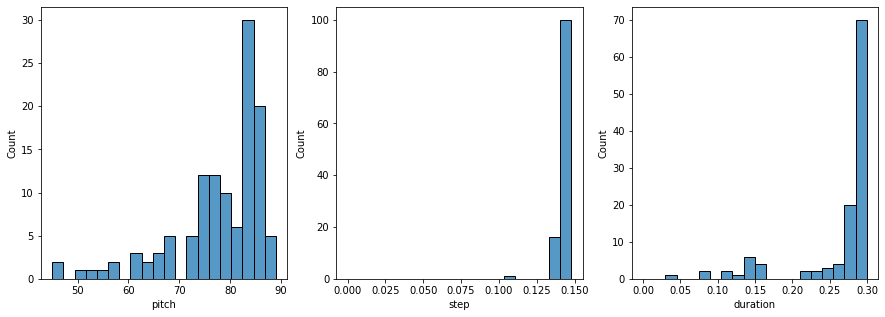

In [48]:
plot_distributions(generated_notes)

In the above plots, you will notice the change in distribution of the note variables. Since there is a feedback loop between the model's outputs and inputs, the model tends to generate similar sequences of outputs to reduce the loss. This is particularly relevant for step and duration, which uses the MSE loss. For pitch, you can increase the randomness by increasing the temperature in predict_next_note.

Next steps
This tutorial demonstrated the mechanics of using an RNN to generate sequences of notes from a dataset of MIDI files. To learn more, you can visit the closely related Text generation with an RNN tutorial, which contains additional diagrams and explanations.

One of the alternatives to using RNNs for music generation is using GANs. Rather than generating audio, a GAN-based approach can generate an entire sequence in parallel. The Magenta team has done impressive work on this approach with GANSynth. You can also find many wonderful music and art projects and open-source code on Magenta project website.